In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn import preprocessing

import xgboost as xgb
from xgboost import plot_importance

In this notebook we are going to use the XGBoost algorithm to create a baseline model that we will compare our future models against. We are using XGBoost here because it's a powerful algorithm that can handle missing values, thus allowing us to create a relatively strong model without having to make any decisions that could negatively affect the quality of our data (e.g., imputation). 

*Note: In future notebooks we will clean this data up, impute missing values, do some feature engineering utilizing all of the dataset's tables, build more advanced models, and see if these newer models can't improve on the baseline model we are about to build.*

Let's start by loading in the primary table from the training data. (This is the only table we will be using in this notebook.)

In [2]:
df = pd.read_csv("../input/application_train.csv")

Let's get rid of the MODE and MEDI predictors that have an AVG counterpart, as these are all highly correlated (see the Exploratory Analysis notebook).

In [3]:
df.drop(df.loc[:,'APARTMENTS_MODE':'NONLIVINGAREA_MEDI'].columns, axis=1, inplace=True)

Our predictors and their datatypes are now as follows:

In [4]:
print(df.dtypes.to_string())

SK_ID_CURR                       int64
TARGET                           int64
NAME_CONTRACT_TYPE              object
CODE_GENDER                     object
FLAG_OWN_CAR                    object
FLAG_OWN_REALTY                 object
CNT_CHILDREN                     int64
AMT_INCOME_TOTAL               float64
AMT_CREDIT                     float64
AMT_ANNUITY                    float64
AMT_GOODS_PRICE                float64
NAME_TYPE_SUITE                 object
NAME_INCOME_TYPE                object
NAME_EDUCATION_TYPE             object
NAME_FAMILY_STATUS              object
NAME_HOUSING_TYPE               object
REGION_POPULATION_RELATIVE     float64
DAYS_BIRTH                       int64
DAYS_EMPLOYED                    int64
DAYS_REGISTRATION              float64
DAYS_ID_PUBLISH                  int64
OWN_CAR_AGE                    float64
FLAG_MOBIL                       int64
FLAG_EMP_PHONE                   int64
FLAG_WORK_PHONE                  int64
FLAG_CONT_MOBILE         

Below are the categorical predictors with "object" datatypes and how many levels they have.

In [5]:
categorical_columns = df.select_dtypes(include='object')
label_encoder = preprocessing.LabelEncoder()

for col in categorical_columns:
    num_levels = len(df[col].unique())
    print(col, num_levels)

NAME_CONTRACT_TYPE 2
CODE_GENDER 3
FLAG_OWN_CAR 2
FLAG_OWN_REALTY 2
NAME_TYPE_SUITE 8
NAME_INCOME_TYPE 8
NAME_EDUCATION_TYPE 5
NAME_FAMILY_STATUS 6
NAME_HOUSING_TYPE 6
OCCUPATION_TYPE 19
WEEKDAY_APPR_PROCESS_START 7
ORGANIZATION_TYPE 58
FONDKAPREMONT_MODE 5
HOUSETYPE_MODE 4
WALLSMATERIAL_MODE 8
EMERGENCYSTATE_MODE 3


The "ORGANIZATION_TYPE" predictor is especially ugly with way too many levels, so we are going to throw this out in a bit. Luckily, a lot of the information contained in this predictor should also be contained in the "OCCUPATION_TYPE" and "AMT_INCOME_TOTAL" predictors, so we shouldn't lose too much information here.

In [6]:
df['ORGANIZATION_TYPE'].unique()

array(['Business Entity Type 3', 'School', 'Government', 'Religion',
       'Other', 'XNA', 'Electricity', 'Medicine',
       'Business Entity Type 2', 'Self-employed', 'Transport: type 2',
       'Construction', 'Housing', 'Kindergarten', 'Trade: type 7',
       'Industry: type 11', 'Military', 'Services', 'Security Ministries',
       'Transport: type 4', 'Industry: type 1', 'Emergency', 'Security',
       'Trade: type 2', 'University', 'Transport: type 3', 'Police',
       'Business Entity Type 1', 'Postal', 'Industry: type 4',
       'Agriculture', 'Restaurant', 'Culture', 'Hotel',
       'Industry: type 7', 'Trade: type 3', 'Industry: type 3', 'Bank',
       'Industry: type 9', 'Insurance', 'Trade: type 6',
       'Industry: type 2', 'Transport: type 1', 'Industry: type 12',
       'Mobile', 'Trade: type 1', 'Industry: type 5', 'Industry: type 10',
       'Legal Services', 'Advertising', 'Trade: type 5', 'Cleaning',
       'Industry: type 13', 'Trade: type 4', 'Telecom',
       'I

We now give the categorical predictors numerical levels:

In [7]:
for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col].astype(str))

Next, we drop the ID and ORGANIZATION_TYPE columns, the first because it has no predictive use, and the second because it has way too many levels (as we saw above). We then split our data into a training set (80%) and a validation set (20%).

In [8]:
y = df['TARGET']
X = df.drop(['SK_ID_CURR','TARGET','ORGANIZATION_TYPE'], axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2)

Let's now build our XGBoost model.

*Note: Since we have such an imbalanced dataset (approx 91.9% of the responses are 0), we are always going to use the AUC metric to evaluate model fit.*

Below we fit an XGBoost Classifier to our training data with some pretty generic boosting parameters, which will be fine-tuned later. The below boosting process is intended to find a good number of boosting rounds to perform, stopping when we stop noticing an increase in the validation set's AUC score.

In [9]:
eval_set = [(X_val, y_val)]

xgb1 = xgb.XGBClassifier(
 learning_rate = 0.1,
 n_estimators=500,
 max_depth=5,
 min_child_weight=1,
 subsample=1,
 colsample_bytree=1,
 objective= 'binary:logistic',
 seed=1)

xgb1.fit(X_train, y_train, early_stopping_rounds = 25, eval_metric="auc", eval_set=eval_set, verbose=False)

print("Optimal boosting rounds: {} \nAUC Score: {}".format(xgb1.get_booster().best_ntree_limit, xgb1.get_booster().best_score))


Optimal boosting rounds: 181 
AUC Score: 0.755684


Next, we set the number of boosting rounds ('n_estimators') to 181 and use 5-fold cross-validation to fine-tune our boosting parameters in order of decreasing importance. First we tune the max_depth and min_child_weight of our boosting trees. Then we tune the subsample and colsample_bytree parameters. The purported optimal values are in the code below, and the values we tested are commented out to their right.

In [ ]:
param_grid = {
    'learning_rate': [.1],
    'n_estimators': [181],
    'max_depth': [4],             #tested [3,4,5,6,7]
    'min_child_weight': [2],      #tested [1,2,3,4]
    'subsample': [.8],       #tested [.7,.75,.8,.85,.9,1]
    'colsample_bytree': [.8],    #tested [.7,.75,.8,.85,.9]
}

xgb_clf = xgb.XGBClassifier(random_state=1, objective='binary:logistic')

cv_xgb = GridSearchCV(estimator = xgb_clf, param_grid = param_grid, n_jobs = -1, cv = 5, scoring='roc_auc')
cv_xgb.fit(X_train,y_train)

best_xgb = cv_xgb.best_estimator_
print(cv_xgb.best_score_, cv_xgb.best_params_)

Now we keep the above boosting parameters, lower the learning rate, and repeat our initial step to further optimize the number of boosting rounds:

In [12]:
xgb_baseline_model = xgb.XGBClassifier(
 learning_rate = 0.05,
 n_estimators=5000,
 max_depth=4,
 min_child_weight=2,
 subsample=.8,
 colsample_bytree=.8,
 objective= 'binary:logistic',
 seed=1)

xgb_baseline_model.fit(X_train, y_train, early_stopping_rounds = 50, eval_metric="auc", eval_set=eval_set, verbose=False)

print("Optimal boosting rounds: {} \nAUC Score: {}".format(xgb_baseline_model.get_booster().best_ntree_limit, xgb_baseline_model.get_booster().best_score))

Optimal boosting rounds: 742 
AUC Score: 0.758855


When we increase the number of boosting rounds to 742 our validation set's AUC score rises to 0.758855. So, our baseline model has the following boosting parameters:

learning_rate = 0.05, n_estimators=742, max_depth=4, min_child_weight=2, subsample=.8, colsample_bytree=.8, objective= 'binary:logistic', seed=1

And below is a plot of feature importance as determined by our baseline model:

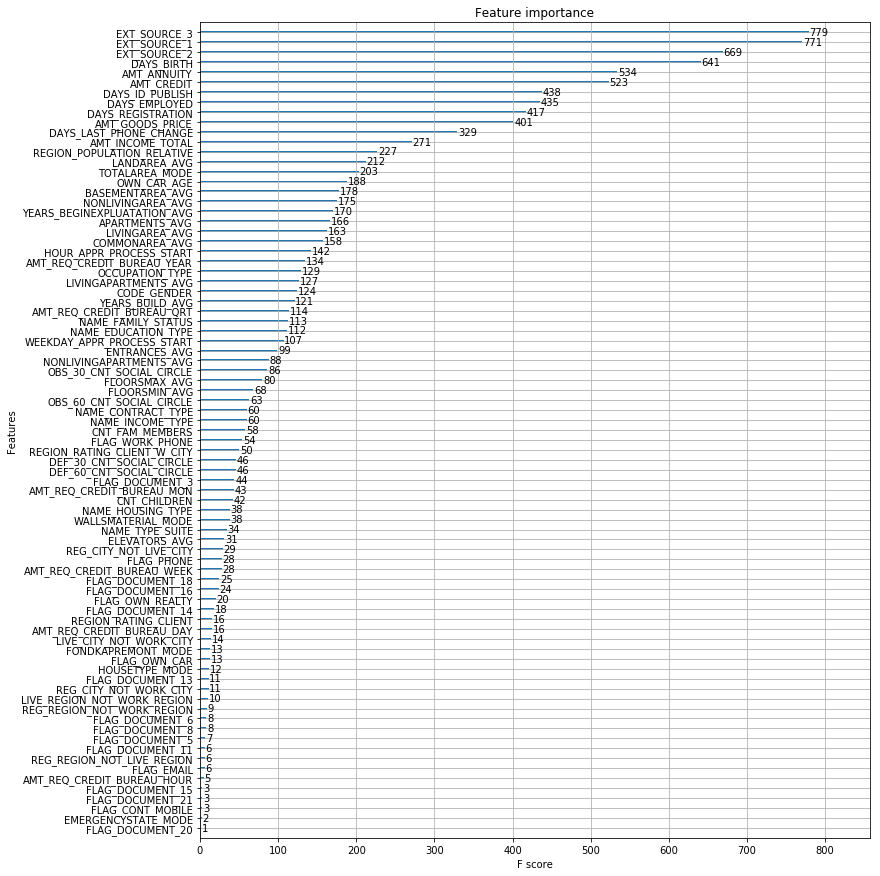

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 15))
plot_importance(xgb_baseline_model, ax=ax)

Finally, below are the AUC scores for the training and validation sets, respectively.

In [14]:
metrics.roc_auc_score(y_train, xgb_baseline_model.predict_proba(X_train)[:,1])

0.8038127541889845

In [15]:
metrics.roc_auc_score(y_val, xgb_baseline_model.predict_proba(X_val)[:,1])

0.7588547215621716